# Architectural Tradeoff Analysis (PCA)

In [53]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
from adjustText import adjust_text
from pcatools import *
from tabulate import tabulate
import os
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math

In [25]:
path = "C:/Users/KOQVIST1/architectural-tradeoff-analysis/Simulation data/"
filedir = "April13/combined.csv"
df = pd.DataFrame(pd.read_csv((path+filedir)))

full_length = len(df)

# Clean data by dropping inf values (and NaN)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop_duplicates()

cleaned_length = len(df)

number_of_topologies = len([x for x in df.columns if x[0].isdigit()])

## Data Display

In [26]:
cost_uplim = None
cost_lowlim = None
latency_uplim = None
latency_lowlim = None
complexity_uplim = None
complexity_lowlim = None
scalability_uplim = None
scalability_lowlim = None

topologies_in = [1.1, 1.2, 1.3, 1.4, 2.1, 2,2, 3.0];

df_filtered = df.copy();

if cost_uplim != None:
    df_filtered = df_filtered.loc[df_filtered['cost'] < cost_uplim]
if cost_lowlim != None:
    df_filtered = df_filtered.loc[df_filtered['cost'] > cost_lowlim]
if latency_uplim != None:
    df_filtered = df_filtered.loc[df_filtered['latency'] < latency_uplim]
if latency_lowlim != None:    
    df_filtered = df_filtered.loc[df_filtered['latency'] > latency_lowlim]
if complexity_uplim != None:
    df_filtered = df_filtered.loc[df_filtered['complexity'] < complexity_uplim]
if complexity_lowlim != None:    
    df_filtered = df_filtered.loc[df_filtered['complexity'] > complexity_lowlim]
if scalability_uplim != None:
    df_filtered = df_filtered.loc[df_filtered['scalability'] < scalability_uplim]
if scalability_lowlim != None:    
    df_filtered = df_filtered.loc[df_filtered['scalability'] > scalability_lowlim]

df_filtered = df_filtered[df['Topology'].isin(topologies_in)]

filtered_length = len(df_filtered)

print("Data statistics: " + filedir + "\n" 
    + "Original size: " + str(full_length) + " rows \n" 
    + "Cleaned size: " + str(cleaned_length) + " rows \n"
    + "Dulicated: " + str(full_length - cleaned_length) + " rows \n"
    + "Filtered size: " + str(filtered_length) + " rows \n"
    + "Dimension: " + str(len(df.columns)) + " columns \n"
    + "Topologies count: " + str(number_of_topologies) + "\n"
    + "Topologies: " + ', '.join([str(topo) for topo in df.columns[0:number_of_topologies]]))

#topoScatterPrint(df_filtered, 'latency','cost', False)
#topoScatterPrint(df_filtered, 'latency','scalability', False)
#topoScatterPrint(df_filtered, 'latency','complexity', False)

#topoScatterPrint(df_filtered, 'scalability','cost', False)
#topoScatterPrint(df_filtered, 'scalability','complexity', False)

#topoScatterPrint(df_filtered, 'complexity','cost', False)
printParameterScatter(df_filtered, ["latency", "cost","complexity","scalability"],None, "Quality Metrics")



Data statistics: April13/combined.csv
Original size: 14000 rows 
Cleaned size: 12136 rows 
Dulicated: 1864 rows 
Filtered size: 10136 rows 
Dimension: 32 columns 
Topologies count: 7
Topologies: 1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 3.0


# Pareto Front Optimisation

In [ ]:
pareto_targets = ['latency', 'cost']
pareto_objectives = ["min", "min"]
df_pareto = paretoOptimize(df_filtered,pareto_targets, pareto_objectives, iterations = 10)
printPareto(df_filtered,df_pareto, pareto_targets, True)

'pareto_targets = [\'latency\', \'cost\']\npareto_objectives = ["min", "min"]\ndf_pareto = paretoOptimize(df_filtered,pareto_targets, pareto_objectives, iterations = 10)\nprintPareto(df_filtered,df_pareto, pareto_targets, True)'

# PCA Analysis

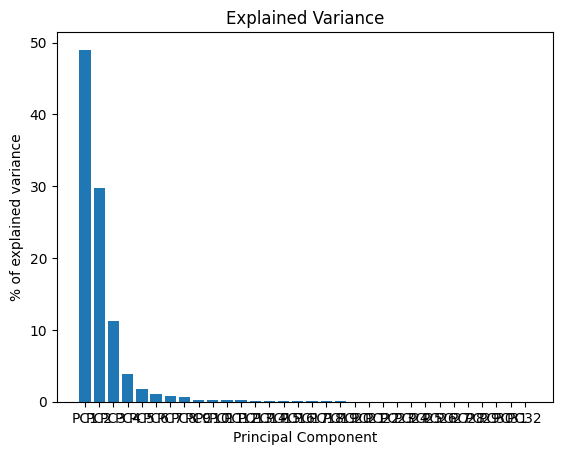

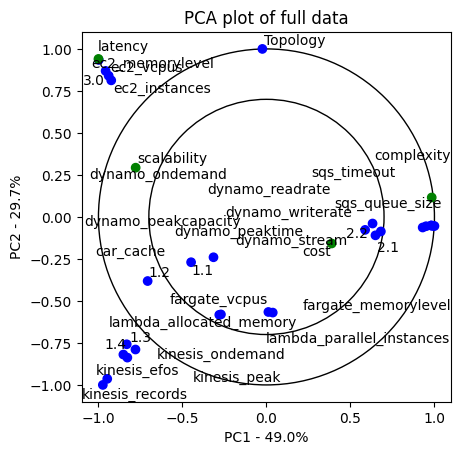

In [28]:
# Same for full matrix (without pareto)
corr_full = df.corr()
corr_full = corr_full.fillna(0)

# assign categories
buckets = [0] * len(df.columns);
buckets[-4:] = [1, 1, 1, 1];
categories = np.array(buckets)
 
# use colormap
colormap = np.array(['b', 'g'])
pca, pca_data = createPCA(corr_full)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_full, 'PCA plot of full data',categories=categories, colormap=colormap)

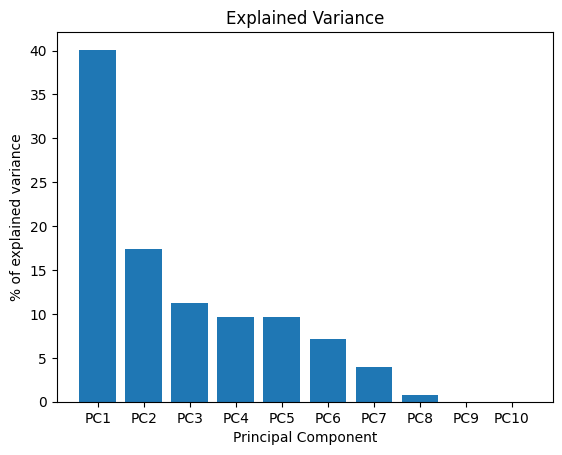

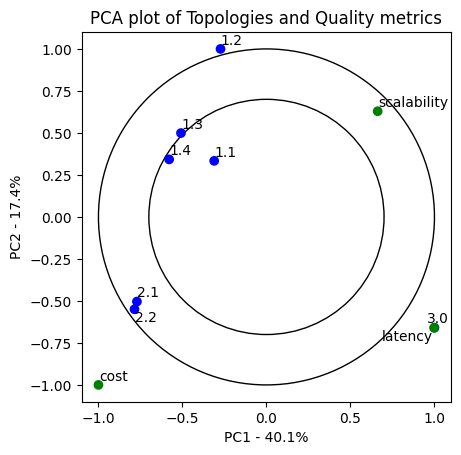

In [19]:
desired_cols = ['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '3.0', 'cost','latency','scalability']
df_topo = df[desired_cols]

corr_topo = scaleData(df_topo).corr()
corr_topo = corr_topo.fillna(0)

# assign categories
buckets = [0] * len(df_topo.columns);
buckets[-3:] = [1, 1, 1];
categories = np.array(buckets)

pca, pca_data = createPCA(corr_topo)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_topo, 'PCA plot of Topologies and Quality metrics',categories=categories, colormap=colormap)

# 1: Choosing Topology

In [223]:
topologies = df['Topology'].unique()
df_mean = pd.DataFrame()

df_mean = df.groupby("Topology")[['latency','cost','complexity','scalability']].mean()

#df_mean['complexity'] = np.log(df_mean['complexity']).multiply(1)
df_mean['complexity'] = df_mean['complexity'].multiply(0.4).add(-2)
df_mean['scalability']=(df_mean['scalability']-df_mean['scalability'].mean())/df_mean['scalability'].std()
df_mean['scalability'] = df_mean['scalability'].add(4)
df_mean['cost'] = np.log10(df_mean['cost']).multiply(2.5)
df_mean['latency'] = df_mean['latency'].multiply(100000)
df_mean['latency'] = np.log(df_mean['latency']).multiply(0.2).add(3.5)

print(df_mean)

#df_mean

           latency      cost  complexity  scalability
Topology                                             
1.1       2.539817  1.195202         0.0     5.117886
1.2       1.800721  1.291238         0.0     4.728976
1.3       2.519823  0.846553         1.6     3.404636
1.4       1.880867  0.974168         1.6     3.023773
2.1       2.542181  4.380029         4.4     3.233524
2.2       3.177097  4.414037         4.4     3.196003
3.0       5.698332  1.161758         2.0     5.295202


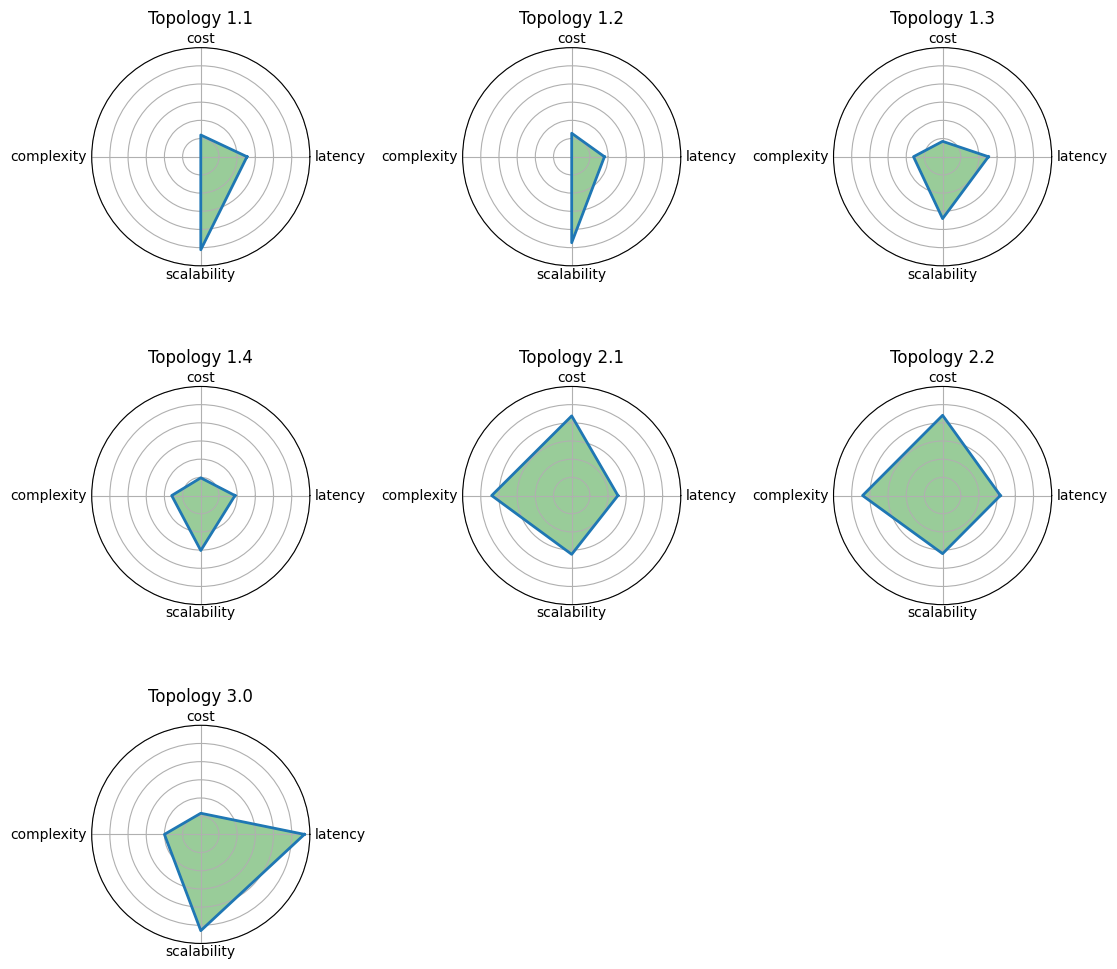

In [224]:
# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(3, 3, subplot_kw=dict(projection='polar'), figsize=(12, 12))

idx = 0
for x in range(3) :
    for y in range(3):
        if (x*3 + y) >= len(df_mean) :
            break
        mean_list = df_mean.iloc[idx].to_list()
        mean_list.append(mean_list[0])
        axs[x,y].plot(angles, mean_list, linewidth=2, linestyle='solid')
        axs[x,y].fill(angles, mean_list, c='g', alpha=0.4)
        axs[x,y].set_thetagrids(np.degrees(angles[:-1]), df_mean.columns)
        axs[x,y].set_title("Topology " + str(df_mean.index[idx]), fontsize=12)
        axs[x,y].grid(True)
        axs[x,y].set_yticklabels([])
        idx += 1

# Hide the empty subplots
for i in range(3):
    for j in range(3):
        if i == 2 and j > 0:
            axs[i, j].axis('off')

for i, ax in enumerate(axs.flat):
    idx = 0
    for label in ax.xaxis.get_ticklabels():
        if idx == 0 :
            label.set_position((label.get_position()[0], label.get_position()[1]-0.1))
        if idx == 1 :
            label.set_position((label.get_position()[0], label.get_position()[1]+0.1))
        if idx == 2 :
            label.set_position((label.get_position()[0], label.get_position()[1]-0.22))
        if idx == 3 :
            label.set_position((label.get_position()[0], label.get_position()[1]+0.1))

        idx += 1


# Set the ylim for all subplots to be the same
for ax in axs.flat:
    ax.set_ylim(0, 6)

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=0.2)

# Show the plot
plt.show()